문제: 생선 데이터를 이용하여 무슨 생선일지 7개의 생선에 대한 확률을 출력해야 함.

## 럭키백의 확률

### 데이터 준비하기

In [1]:
import pandas as pd

fish = pd.read_csv('https://bit.ly/fish_csv_data')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


pd.unique를 이용하여 class를 확인한다.

In [2]:
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


데이터를 nparray로 바꾼다.

In [3]:
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()

In [4]:
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


In [5]:
fish_target = fish['Species'].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### k-최근접 이웃 분류기의 확률 예측

K를 3으로 하여 훈련

In [8]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)

print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


In [9]:
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [10]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


kn.predict_proba 함수를 이용하여 샘플에 대해 클래스별 확률을 계산하여 출력함.

In [11]:
import numpy as np

proba = kn.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=4))

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


In [12]:
distances, indexes = kn.kneighbors(test_scaled[3:4])
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


Problem: knn을 이용하여 확률을 보려고 한다면 가능한 확률은 0, 1/3, 2/3, 1 밖에 없음. 이는 우리가 원하던 확률과는 거리가 멈.

## 로지스틱 회귀

로지스틱 회귀: 분류 알고리즘 중 하나로, 선형 방정식을 학습하여 z값을 계산하고 z를 시그모이드 함수(또는 로지스틱 함수)에 넣어서 이를 확률로 사용한다.

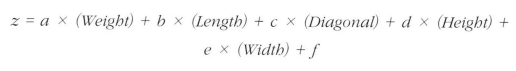

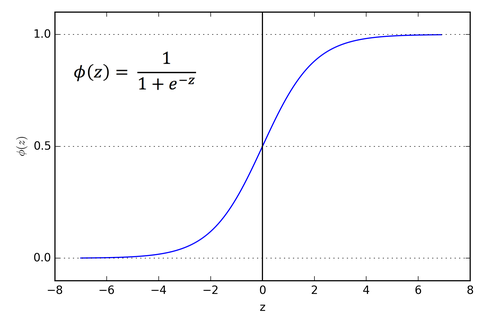

numpy와 matplotlib을 활용하여 시그모이드 함수 그리기.

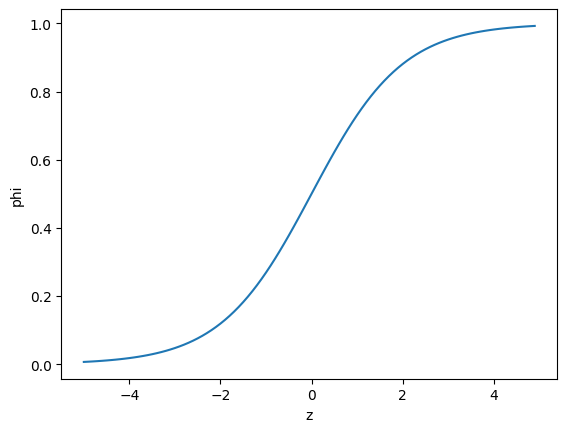

In [13]:
import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1)
phi = 1 / (1 + np.exp(-z))

plt.plot(z, phi)
plt.xlabel('z')
plt.ylabel('phi')
plt.show()

### 로지스틱 회귀로 이진 분류 수행하기

Bream과 Smelt인 데이터만 뽑아내기 위해 인덱스를 가져오고 이를 활용하여 X와 y데이터에서 도미와 빙어 데이터만 골라낸다.

In [15]:
bream_smelt_indexes = (train_target == 'Bream') | (train_target == 'Smelt')
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

로지스틱 회귀를 이용하여 이진 분류 수행

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

LogisticRegression()

In [17]:
print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


확률 확인

In [18]:
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99759855 0.00240145]
 [0.02735183 0.97264817]
 [0.99486072 0.00513928]
 [0.98584202 0.01415798]
 [0.99767269 0.00232731]]


In [19]:
print(lr.classes_)

['Bream' 'Smelt']


계수 확인

In [20]:
print(lr.coef_, lr.intercept_)

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]


z값 확인

In [21]:
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]


In [22]:
from scipy.special import expit

print(expit(decisions))

[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


### 로지스틱 회귀로 다중 분류 수행하기

```
def __init__(
        self,
        penalty="l2", # 규제는 l2(ridge)
        *,
        dual=False,
        tol=1e-4,
        C=1.0, # alpha처럼 규제의 강도를 조절하는 변수,
                 다만 alpha와 반대로 작을수록 규제가 커짐
        fit_intercept=True,
        intercept_scaling=1,
        class_weight=None,
        random_state=None,
        solver="lbfgs",
        max_iter=100, # 반복 횟수
        multi_class="auto",
        verbose=0,
        warm_start=False,
        n_jobs=None,
        l1_ratio=None,
    ):
```

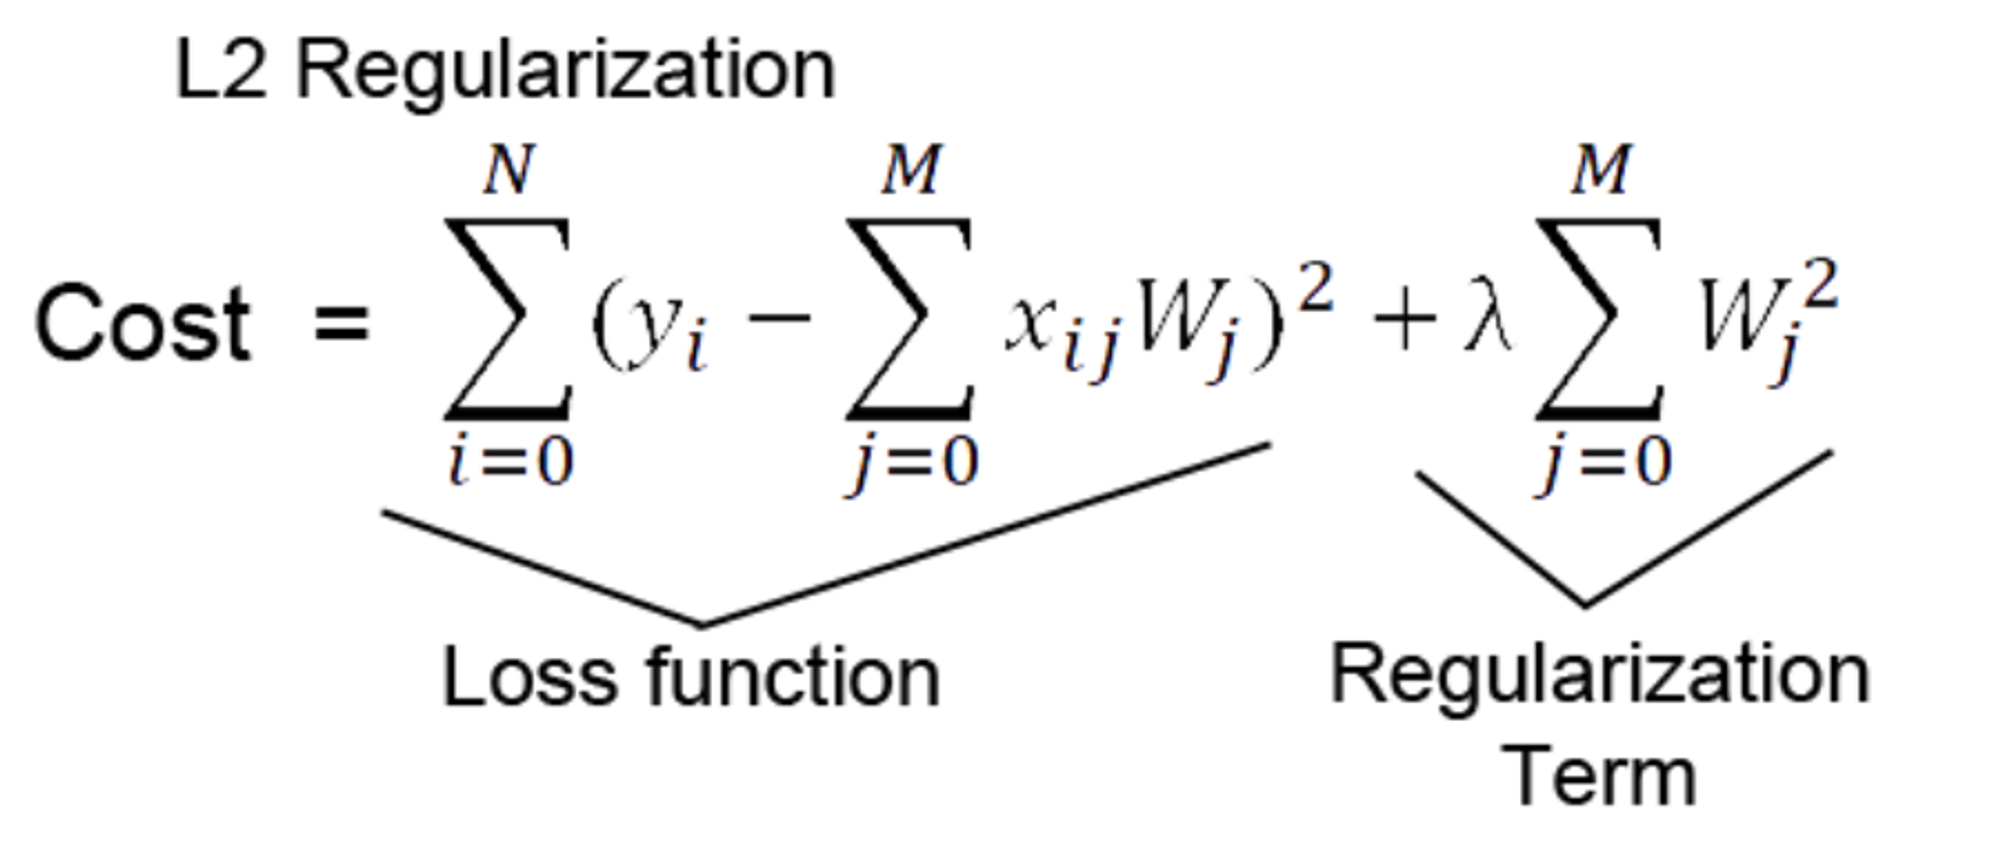

In [23]:
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


In [24]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


확률 확인

In [25]:
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [26]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


**다중 분류 계산 방식**  

z값을 클래스 갯수 만큼 계산하여 가장 높은 z값을 갖는 클래스가 예측 클래스가 됨.  
또한 확률은 소프트맥스 함수를 사용하여 z값을 확률로 변환.
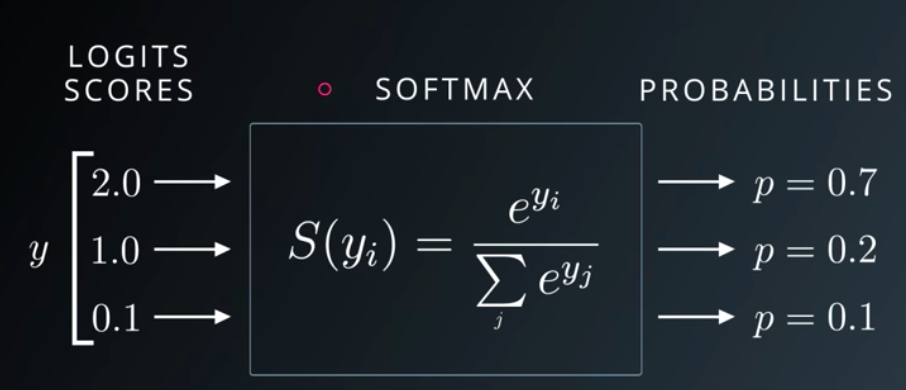

음수라면? 0으로 변환

In [27]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


In [28]:
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.5    1.03   5.16  -2.73   3.34   0.33  -0.63]
 [-10.86   1.93   4.77  -2.4    2.98   7.84  -4.26]
 [ -4.34  -6.23   3.17   6.49   2.36   2.42  -3.87]
 [ -0.68   0.45   2.65  -1.19   3.26  -5.75   1.26]
 [ -6.4   -1.99   5.82  -0.11   3.5   -0.11  -0.71]]


scipy의 softmax로도 구해보기

In [29]:
from scipy.special import softmax

proba = softmax(decision, axis=1)
print(np.round(proba, decimals=3))

[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]
